# library import

* 상급종합병원 및 종합병원 입원의료 이용 현황
    * https://kosis.kr/statHtml/statHtml.do?orgId=331&tblId=DT_920012N_1033&vw_cd=MT_ZTITLE&list_id=331_33110_001_005&seqNo=&lang_mode=ko&language=kor&obj_var_id=&itm_id=&conn_path=MT_ZTITLE

* 대중교통 데이터
    * https://stcis.go.kr/wps/dashBoard.do

In [216]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from matplotlib import rc
import warnings
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler


if os.name == 'nt':
    print("This is a Windows environment.")
    rc('font', family='Malgun Gothic')
elif os.name == 'posix':
    print("This is a Mac or Linux environment.")
    rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

warnings.filterwarnings("ignore", category=UserWarning)

This is a Mac or Linux environment.


In [217]:
files = glob('./data/output/*.csv')
files

['./data/output/traffic_f.csv',
 './data/output/welfare_f.csv',
 './data/output/apartments_f.csv',
 './data/output/medical_f.csv',
 './data/output/culture_f.csv']

In [218]:
traffic = pd.read_csv(files[0])
welfare = pd.read_csv(files[1])
apartments = pd.read_csv(files[2])
medical = pd.read_csv(files[3])
culture = pd.read_csv(files[4])

In [219]:
medical['의료시설개수'] = medical['병원수'] + medical['약국개수']

In [220]:
traffic['기준개수(10K)'] = traffic['BusStop_Count'] / traffic['노령인구_전체'] * 10000
welfare['기준개수(10K)'] = welfare['개수'] / welfare['노령인구'] * 10000
medical['기준개수(10K)'] = medical['의료시설개수'] / medical['노령인구'] * 10000
culture['기준개수(10K)'] = culture['문화시설개수'] / culture['노령인구'] * 10000

In [221]:
def scoring(df, column):
    df_value = df[column].values
    _, p_value = stats.shapiro(df_value)
    
    if p_value >= 0.05:
        print("해당 데이터는 정규분포를 따릅니다")
        print(round(p_value, 2))
        print('----------------------------')
        mean_value = np.mean(df_value)
        std_value = np.std(df_value)
        z_score_list = []
        t_score_list = []
        for value in df[column]:
            z_score = (value - mean_value) / std_value
            z_score_list.append(z_score)
            
            t_score = (10 * z_score) + 50
            t_score_list.append(t_score)
        
        df['z_score'] = z_score_list
        df['t_score'] = t_score_list
        
        return df
    else:
        print("해당 데이터는 정규분포를 따르지않습니다, 변환을 시도합니다.")
        print(round(p_value, 2))
        print('----------------------------')
        
        log_transform_data = np.log(df[column])
        
        scaler = RobustScaler()
        scaled_data = scaler.fit_transform(df[[column]])
        scaled_data = scaled_data.flatten()

        boxcox_transform_data, lambda_param = stats.boxcox(df[column])
        
        data_list = [(scaled_data, 'RobustScaler'), (log_transform_data, 'Log Transform'), (boxcox_transform_data, 'Box-cox')]
        
        for _, (data, method) in enumerate(data_list):
            _, transform_p_value = stats.shapiro(data)
            
            if transform_p_value >= 0.05:
                print(f"{method}를 통해 정규분포로 변경 되었습니다.")
                print(transform_p_value)
                print('----------------------------')
                
                mean_value = np.mean(data)
                std_value = np.std(data)
                
                z_score_list = [(value - mean_value) / std_value for value in data]

                t_score_list = [(10 * z_score) + 50 for z_score in z_score_list]
                
                df[f"{method}_z_score"] = z_score_list
                df[f'{method}_t_score'] = t_score_list
                
                return df
            else:
                print("---------")
                print(f"{method}는 p값이 {transform_p_value} 므로 적정하지 않습니다.")
                print("---------")
            
        print("변환 후에도 정규분포를 따르지 않습니다.")
        return df

In [230]:
traffic_score = scoring(traffic, '기준개수(10K)')
welfare_score = scoring(welfare, '기준개수(10K)')
apart_score = scoring(apartments, '환산월세금(만원)')
culture_score = scoring(culture, '기준개수(10K)')
medical_score = scoring(medical, '기준개수(10K)')

해당 데이터는 정규분포를 따르지않습니다, 변환을 시도합니다.
0.0
----------------------------
---------
RobustScaler는 p값이 0.000384908799583866 므로 적정하지 않습니다.
---------
Log Transform를 통해 정규분포로 변경 되었습니다.
0.29732836120000633
----------------------------
해당 데이터는 정규분포를 따르지않습니다, 변환을 시도합니다.
0.0
----------------------------
---------
RobustScaler는 p값이 1.6990314264071785e-05 므로 적정하지 않습니다.
---------
---------
Log Transform는 p값이 0.0010683085325300815 므로 적정하지 않습니다.
---------
Box-cox를 통해 정규분포로 변경 되었습니다.
0.27531916594429456
----------------------------
해당 데이터는 정규분포를 따릅니다
0.14
----------------------------
해당 데이터는 정규분포를 따르지않습니다, 변환을 시도합니다.
0.0
----------------------------
---------
RobustScaler는 p값이 0.00029364591008472957 므로 적정하지 않습니다.
---------
---------
Log Transform는 p값이 0.02162527896864662 므로 적정하지 않습니다.
---------
Box-cox를 통해 정규분포로 변경 되었습니다.
0.5289177345005076
----------------------------
해당 데이터는 정규분포를 따르지않습니다, 변환을 시도합니다.
0.0
----------------------------
---------
RobustScaler는 p값이 0.0001768475773377255 므로 적정하지 않습니다.
--------

In [223]:
welfare.head(3)

,구별,개수,노령인구,기준개수(10K),Box-cox_z_score,Box-cox_t_score
0,강서구,161,98380,16.365115,0.445675,54.456752
1,양천구,140,73126,19.145037,1.012607,60.126071
2,영등포구,136,70566,19.272738,1.032950,60.329502


In [224]:
culture.head(3)

,시군구,공원수,시장개수,노령인구,문화시설개수,기준개수(10K),Box-cox_z_score,Box-cox_t_score
0,종로구,106,9,27187,115,42.299628,1.848225,68.482247
1,중구,72,25,24374,97,39.796504,1.778960,67.789603
2,용산구,107,6,37740,113,29.941706,1.362434,63.624338


In [225]:
columns = ['구별', 't_score']
result_medical = medical_score[['구별', 'Log Transform_t_score']]
result_traffic = traffic[['Gu', 'Log Transform_t_score']]
result_apart = apartments[['구', 't_score']]
result_welfare = welfare[['구별', 'Box-cox_t_score']]
result_culture = culture[['시군구', 'Box-cox_t_score']]

result_medical.columns = columns
result_traffic.columns = columns
result_apart.columns = columns
result_welfare.columns = columns
result_culture.columns = columns

In [226]:
gu_list = ['종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구',
       '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구',
       '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구']

In [227]:
result_medical['medical_score'] = result_medical['t_score'] * 0.3
result_traffic['traffic_score'] = result_traffic['t_score'] * 0.2
result_apart['apart_score'] = result_apart['t_score'] * 0.2
result_welfare['welfare_score'] = result_welfare['t_score'] * 0.15
result_culture['culture_score'] = result_culture['t_score'] * 0.15

gu = pd.DataFrame(data={
    '구별' : gu_list
})

result = gu.merge(left_on='구별', right=result_medical[['구별', 'medical_score']], right_on='구별')
result = result.merge(left_on='구별', right=result_traffic[['구별', 'traffic_score']], right_on='구별')
result = result.merge(left_on='구별', right=result_apart[['구별', 'apart_score']], right_on='구별')
result = result.merge(left_on='구별', right=result_welfare[['구별','welfare_score']], right_on='구별')
result = result.merge(left_on='구별', right=result_culture[['구별', 'culture_score']], right_on='구별')

result.head()

/var/folders/76/295r32t542b3jtvsn34n34s00000gn/T/ipykernel_1525/2708304860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_medical['medical_score'] = result_medical['t_score'] * 0.3
/var/folders/76/295r32t542b3jtvsn34n34s00000gn/T/ipykernel_1525/2708304860.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_traffic['traffic_score'] = result_traffic['t_score'] * 0.2
/var/folders/76/295r32t542b3jtvsn34n34s00000gn/T/ipykernel_1525/2708304860.py:3: SettingWithCopyWarning: 
A value is trying to

,구별,medical_score,traffic_score,apart_score,welfare_score,culture_score
0,종로구,19.294082,13.800723,10.294952,10.446699,10.272337
1,중구,21.022811,14.313867,12.415414,10.528307,10.168440
2,용산구,15.336481,11.663482,15.582810,9.699319,9.543651
3,성동구,15.518127,13.136126,10.765406,7.477374,8.644202
4,광진구,15.266493,9.109580,10.801889,6.904806,5.546843


In [228]:
result['Total_score'] = result['medical_score'] + result['traffic_score'] + result['apart_score'] + result['welfare_score'] + result['culture_score']
result.head()

,구별,medical_score,traffic_score,apart_score,welfare_score,culture_score,Total_score
0,종로구,19.294082,13.800723,10.294952,10.446699,10.272337,64.108793
1,중구,21.022811,14.313867,12.415414,10.528307,10.168440,68.448839
2,용산구,15.336481,11.663482,15.582810,9.699319,9.543651,61.825743
3,성동구,15.518127,13.136126,10.765406,7.477374,8.644202,55.541235
4,광진구,15.266493,9.109580,10.801889,6.904806,5.546843,47.629612


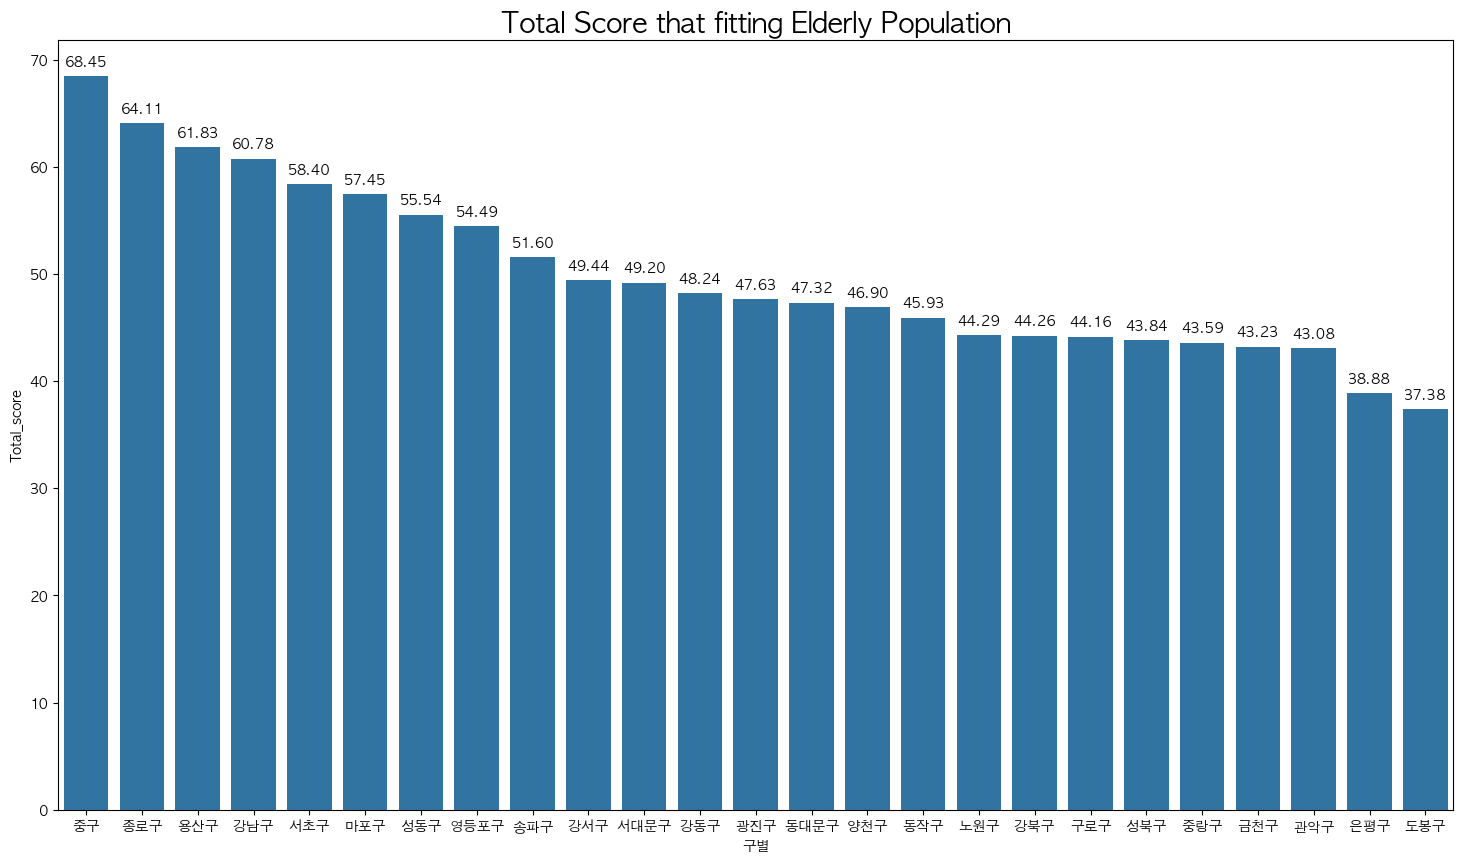

In [229]:
result_sorted = result.sort_values(by='Total_score', ascending=False)

plt.figure(figsize=(18, 10))
ax = sns.barplot(data=result_sorted, x='구별', y='Total_score')
plt.title('Total Score that fitting Elderly Population', fontdict={'fontsize' : 20})
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=10, color='black', 
                xytext=(0, 5), 
                textcoords='offset points')
plt.show()

/var/folders/76/295r32t542b3jtvsn34n34s00000gn/T/ipykernel_1525/1923324706.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(data=top_5, x='구별', y='Total_score', palette='Blues_d')


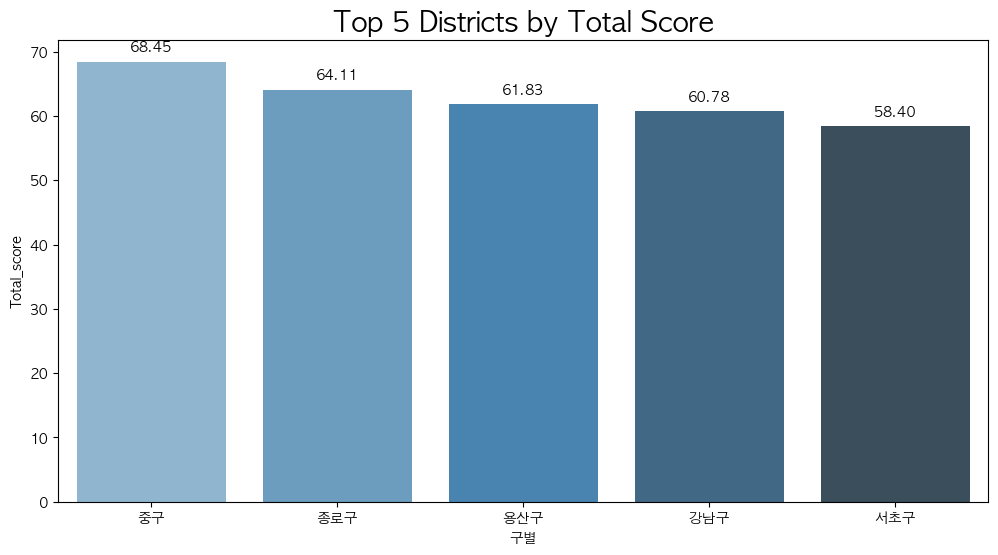

/var/folders/76/295r32t542b3jtvsn34n34s00000gn/T/ipykernel_1525/1923324706.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(data=bottom_5, x='구별', y='Total_score', palette='Reds_d')


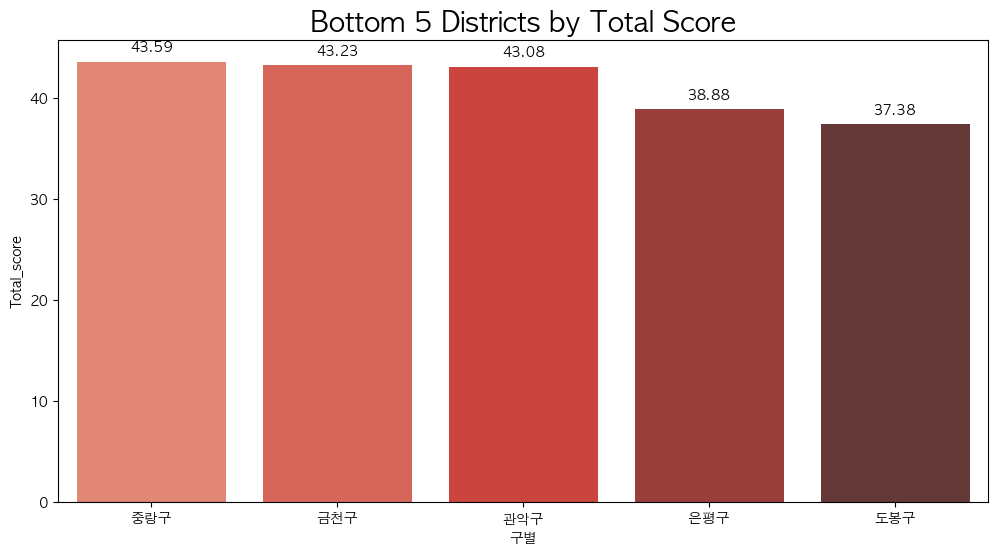

In [233]:
# 상위 5개 데이터
top_5 = result_sorted.head(5)

# 하위 5개 데이터
bottom_5 = result_sorted.tail(5)
# 상위 5개 데이터 시각화
plt.figure(figsize=(12, 6))
ax1 = sns.barplot(data=top_5, x='구별', y='Total_score', palette='Blues_d')
plt.title('Top 5 Districts by Total Score', fontdict={'fontsize': 20})
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2f}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom', 
                 fontsize=10, color='black', 
                 xytext=(0, 5), 
                 textcoords='offset points')
plt.show()

# 하위 5개 데이터 시각화
plt.figure(figsize=(12, 6))
ax2 = sns.barplot(data=bottom_5, x='구별', y='Total_score', palette='Reds_d')
plt.title('Bottom 5 Districts by Total Score', fontdict={'fontsize': 20})
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.2f}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom', 
                 fontsize=10, color='black', 
                 xytext=(0, 5), 
                 textcoords='offset points')
plt.show()


-----------

* box-cox로 비정상적인 p-value 확인

<Axes: xlabel='구별'>

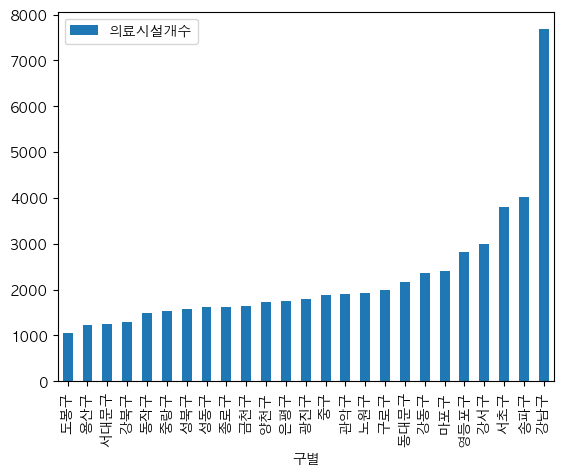

In [132]:
medical_score[['구별', '의료시설개수']].sort_values(by='의료시설개수').set_index("구별").plot(kind='bar')

* 그래프를 확인해보니, 강남구가 너무 치우쳐있음

<Axes: xlabel='구별'>

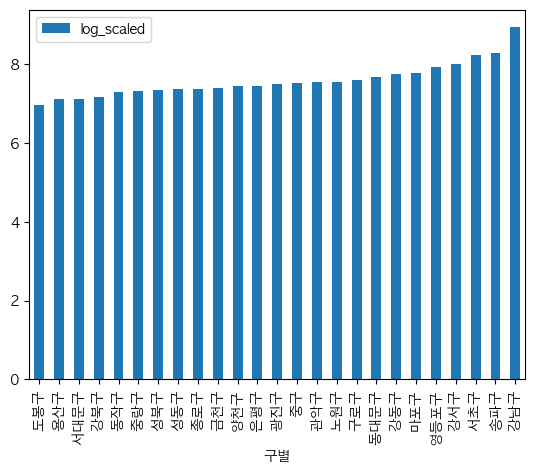

In [135]:
transformlog = np.log(medical['의료시설개수'])

medical['log_scaled'] = transformlog

medical_score[['구별', 'log_scaled']].sort_values(by='log_scaled').set_index("구별").plot(kind='bar')

In [136]:
stats.shapiro(medical['log_scaled'])

ShapiroResult(statistic=0.8944862784129438, pvalue=0.013943045769320914)

* 로그 변환을 시도해도 아직 강남구가 조금 치우쳐져있음

In [148]:
medical.head()

,구별,병원수,병상수,노령인구,약국,한약국,약국개수,병원기준개수(1K),병상기준개수(1K),약국기준개수(1K),의료시설개수,Box-cox_scaled,Box-cox_t_score,log_scaled,log_rbs_scaled,log_mms_scaled,log_sds_scaled
0,종로구,482,3711,27187,957,177,1134,17.729062,136.499062,41.711112,1616,0.960591,59.605913,7.387709,-0.266590,0.215934,-0.266590
1,중구,595,992,24374,1111,175,1286,24.411258,40.699106,52.761139,1881,0.960656,59.606557,7.539559,0.104994,0.292320,0.104994
2,용산구,327,863,37740,785,122,907,8.664547,22.866985,24.032856,1234,0.960449,59.604485,7.118016,-0.926543,0.080268,-0.926543
3,성동구,478,1830,47907,987,145,1132,9.977665,38.199011,23.629115,1610,0.960590,59.605896,7.383989,-0.275692,0.214063,-0.275692
4,광진구,579,2580,55697,1041,182,1223,10.395533,46.322064,21.958095,1802,0.960639,59.606385,7.496652,0.000000,0.270736,0.000000


In [149]:
mms = MinMaxScaler()
medical['log_mms_scaled'] = mms.fit_transform(medical[['log_scaled']])
print(stats.shapiro(medical['log_mms_scaled']))

rbs = RobustScaler()
medical['log_rbs_scaled'] = rbs.fit_transform(medical[['log_scaled']])
print(stats.shapiro(medical['log_rbs_scaled']))

sds = StandardScaler()
medical['log_sds_scaled'] = sds.fit_transform(medical[['log_scaled']])
print(stats.shapiro(medical['log_sds_scaled']))

ShapiroResult(statistic=0.8944862784129435, pvalue=0.013943045769320653)
ShapiroResult(statistic=0.8944862784129435, pvalue=0.013943045769320653)
ShapiroResult(statistic=0.8944862784129435, pvalue=0.013943045769320627)


<Axes: xlabel='구별'>

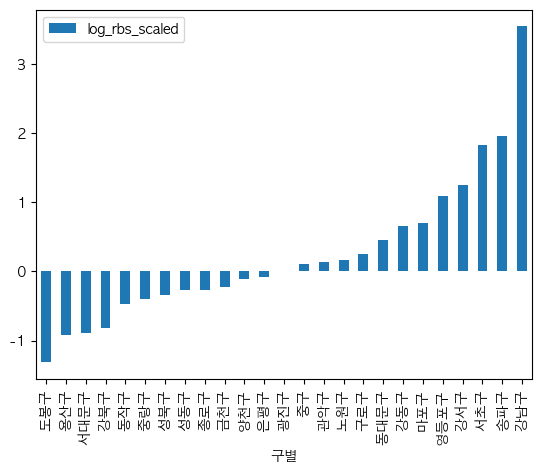

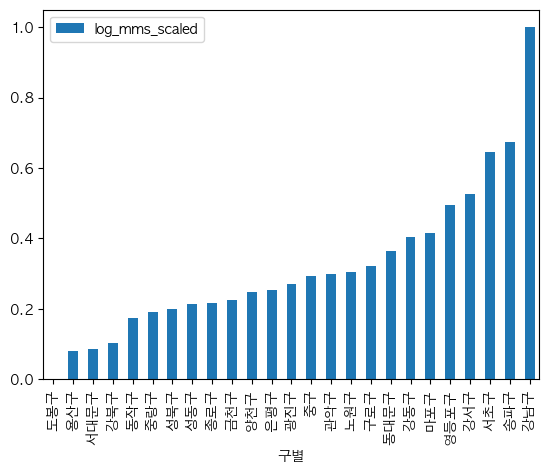

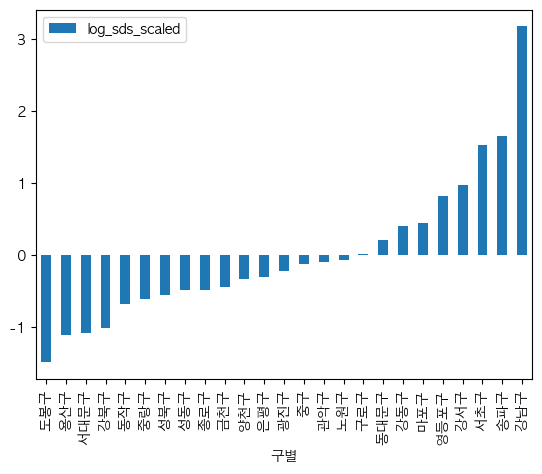

In [151]:
medical_score[['구별', 'log_rbs_scaled']].sort_values(by='log_rbs_scaled').set_index("구별").plot(kind='bar')
medical_score[['구별', 'log_mms_scaled']].sort_values(by='log_mms_scaled').set_index("구별").plot(kind='bar')
medical_score[['구별', 'log_sds_scaled']].sort_values(by='log_sds_scaled').set_index("구별").plot(kind='bar')


* 추가적인 변환을 시도해도 정규성을 확보할 수 없다는 판단 상대적인 순위 기반 평가 후 T-점수 변환 진행

In [153]:
medical['rank'] = medical['의료시설개수'].rank()

In [156]:
# rank를 사용하여 T-점수 변환
rank_z = zscore(medical['rank'])
t_score = 50 + 10 * rank_z  # 평균 50, 표준편차 10인 T-점수로 변환
medical['t_score'] = t_score

In [157]:
medical.head()

,구별,병원수,병상수,노령인구,약국,한약국,약국개수,병원기준개수(1K),병상기준개수(1K),약국기준개수(1K),의료시설개수,Box-cox_scaled,Box-cox_t_score,log_scaled,log_rbs_scaled,log_mms_scaled,log_sds_scaled,rank,t_score
0,종로구,482,3711,27187,957,177,1134,17.729062,136.499062,41.711112,1616,0.960591,59.605913,7.387709,-0.266590,0.215934,-0.487347,9.0,44.452998
1,중구,595,992,24374,1111,175,1286,24.411258,40.699106,52.761139,1881,0.960656,59.606557,7.539559,0.104994,0.292320,-0.130470,14.0,51.386750
2,용산구,327,863,37740,785,122,907,8.664547,22.866985,24.032856,1234,0.960449,59.604485,7.118016,-0.926543,0.080268,-1.121181,2.0,34.745745
3,성동구,478,1830,47907,987,145,1132,9.977665,38.199011,23.629115,1610,0.960590,59.605896,7.383989,-0.275692,0.214063,-0.496090,8.0,43.066248
4,광진구,579,2580,55697,1041,182,1223,10.395533,46.322064,21.958095,1802,0.960639,59.606385,7.496652,0.000000,0.270736,-0.231309,13.0,50.000000


In [162]:
traffic.head(3)

,Gu,BusStop_Count,노령인구_전체,기준개수(1K),z_score,t_score
0,강남구,993,81561,12.174937,1.693251,66.932505
1,강동구,590,80131,7.362943,-0.032721,49.672794
2,강북구,631,65980,9.563504,0.142874,51.428744


In [163]:
welfare.head(3)

,구별,개수,노령인구,기준개수(10K),z_score,t_score
0,강서구,161,98380,16.365115,2.531105,75.311047
1,양천구,140,73126,19.145037,1.617820,66.178195
2,영등포구,136,70566,19.272738,1.443860,64.438604


In [164]:
apartments.head(3)

,구,환산월세금(만원),z_score,t_score
0,강남구,98.319739,1.303606,63.036060
1,강동구,75.909515,-0.511706,44.882937
2,강북구,76.267077,-0.482742,45.172576


In [166]:
culture.head(3)

,시군구,공원수,시장개수,노령인구,문화시설개수,기준개수(10K),z_score,t_score
0,종로구,106,9,27187,115,42.299628,-0.349010,46.509904
1,중구,72,25,24374,97,39.796504,-0.877812,41.221880
2,용산구,107,6,37740,113,29.941706,-0.407765,45.922346


- 의료 접근성: 30%
- 대중교통: 20%
- 주거비용: 20%
- 복지시설 및 여가시설: 각 15%

In [169]:
columns = ['구별', 't_score']
result_medical = medical[['구별', 't_score']]
result_traffic = traffic[['Gu', 't_score']]
result_apart = apartments[['구', 't_score']]
result_welfare = welfare[['구별', 't_score']]
result_culture = culture[['시군구', 't_score']]

result_medical.columns = columns
result_traffic.columns = columns
result_apart.columns = columns
result_welfare.columns = columns
result_culture.columns = columns

In [175]:
gu_list = ['종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구',
       '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구',
       '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구']

In [178]:
result_medical['medical_score'] = result_medical['t_score'] * 0.3
result_traffic['traffic_score'] = result_traffic['t_score'] * 0.2
result_apart['apart_score'] = result_apart['t_score'] * 0.2
result_welfare['welfare_score'] = result_welfare['t_score'] * 0.15
result_culture['culture_score'] = result_culture['t_score'] * 0.15

gu = pd.DataFrame(data={
    '구별' : gu_list
})

result = gu.merge(left_on='구별', right=result_medical[['구별', 'medical_score']], right_on='구별')
result = result.merge(left_on='구별', right=result_traffic[['구별', 'traffic_score']], right_on='구별')
result = result.merge(left_on='구별', right=result_apart[['구별', 'apart_score']], right_on='구별')
result = result.merge(left_on='구별', right=result_welfare[['구별','welfare_score']], right_on='구별')
result = result.merge(left_on='구별', right=result_culture[['구별', 'culture_score']], right_on='구별')

result.head()

/var/folders/76/295r32t542b3jtvsn34n34s00000gn/T/ipykernel_1525/2708304860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_medical['medical_score'] = result_medical['t_score'] * 0.3
/var/folders/76/295r32t542b3jtvsn34n34s00000gn/T/ipykernel_1525/2708304860.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_traffic['traffic_score'] = result_traffic['t_score'] * 0.2
/var/folders/76/295r32t542b3jtvsn34n34s00000gn/T/ipykernel_1525/2708304860.py:3: SettingWithCopyWarning: 
A value is trying to

,구별,medical_score,traffic_score,apart_score,welfare_score,culture_score
0,종로구,13.335899,10.602677,10.294952,6.273588,6.976486
1,중구,15.416025,10.799686,12.415414,5.947415,6.183282
2,용산구,10.423723,9.257875,15.582810,6.404058,6.888352
3,성동구,12.919874,13.258017,10.765406,5.425538,6.712084
4,광진구,15.000000,8.050124,10.801889,5.816946,5.213811


In [179]:
result['Total_score'] = result['medical_score'] + result['traffic_score'] + result['apart_score'] + result['welfare_score'] + result['culture_score']
result.head()

,구별,medical_score,traffic_score,apart_score,welfare_score,culture_score,Total_score
0,종로구,13.335899,10.602677,10.294952,6.273588,6.976486,47.483602
1,중구,15.416025,10.799686,12.415414,5.947415,6.183282,50.761822
2,용산구,10.423723,9.257875,15.582810,6.404058,6.888352,48.556819
3,성동구,12.919874,13.258017,10.765406,5.425538,6.712084,49.080920
4,광진구,15.000000,8.050124,10.801889,5.816946,5.213811,44.882769


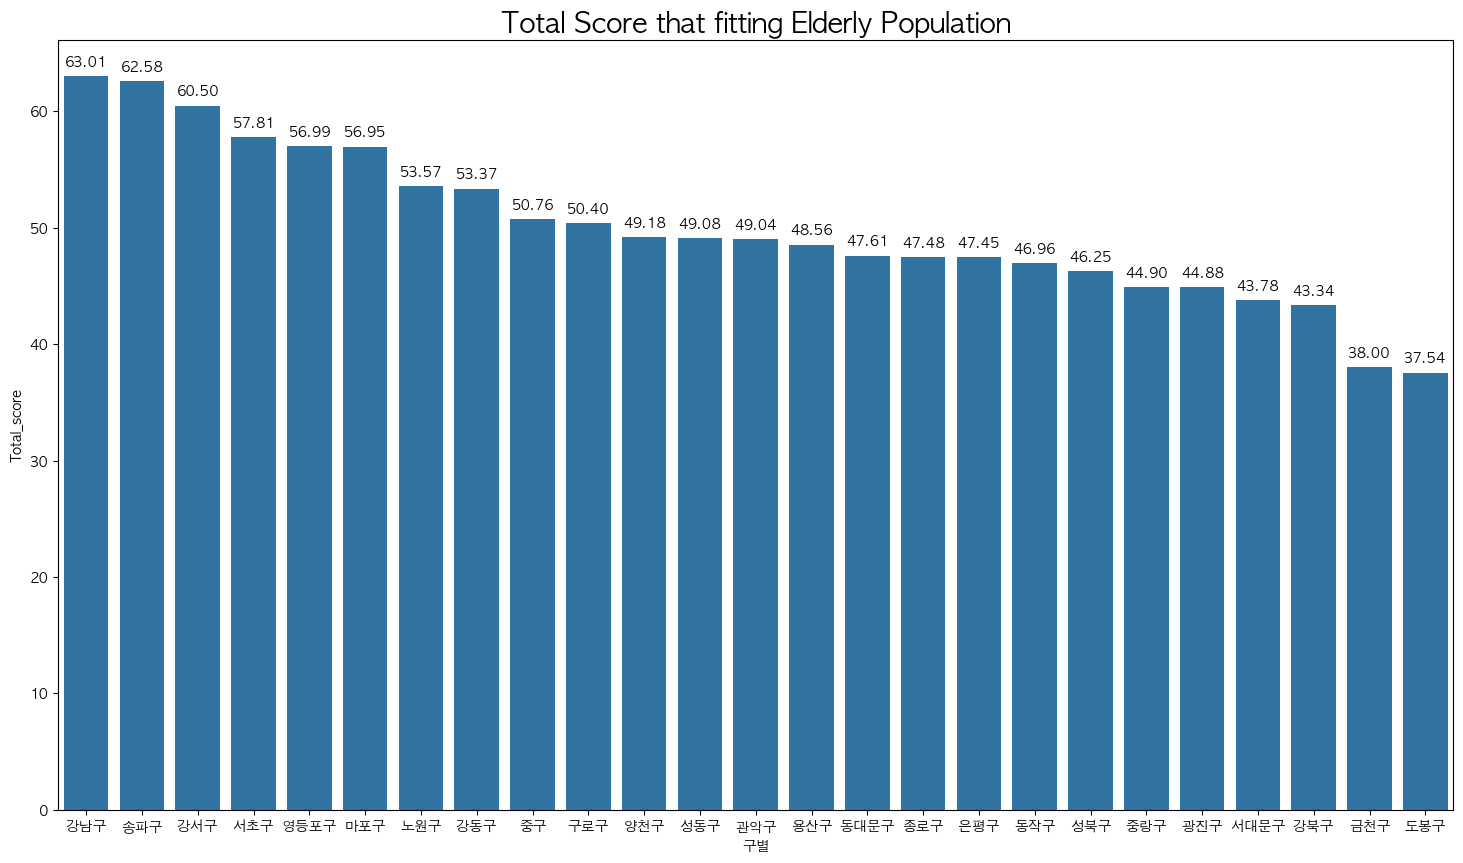

In [180]:
result_sorted = result.sort_values(by='Total_score', ascending=False)

plt.figure(figsize=(18, 10))
ax = sns.barplot(data=result_sorted, x='구별', y='Total_score')
plt.title('Total Score that fitting Elderly Population', fontdict={'fontsize' : 20})
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=10, color='black', 
                xytext=(0, 5), 
                textcoords='offset points')
plt.show()

----

In [4]:
point = pd.DataFrame(data={
    'medical' : [5],
    'traffic' : [4],
    'culture' : [3],
    'welfare' : [2],
    'apartments' : [1]
})

point

,medical,traffic,culture,welfare,apartments
0,5,4,3,2,1


In [5]:
raw_hospital = pd.read_excel('./data/상급종합병원_및_종합병원_입원의료_이용_현황_성__연령__혼인상태__20241221032357.xlsx')
raw_hospital.head(10)

,특성별(1),특성별(2),의료기관별(1),2019,2019.1,2020,2020.1,2021,2021.1
0,특성별(1),특성별(2),의료기관별(1),환자수 (명),백분율 (%),환자수 (명),백분율 (%),환자수 (명),백분율 (%)
1,계,소계,상급종합병원,615,100,521,100,324,100
2,NaN,NaN,종합병원,609,100,547,100,614,100
3,성별,남,상급종합병원,146,23.7,155,29.7,158,48.9
4,NaN,NaN,종합병원,299,49.1,241,44,263,42.8
5,NaN,여,상급종합병원,469,76.3,366,70.3,166,51.1
6,NaN,NaN,종합병원,310,50.9,306,56,351,57.2
7,연령별,10세 미만,상급종합병원,23,3.7,18,3.5,11,3.4
8,NaN,NaN,종합병원,51,8.4,24,4.3,23,3.8
9,NaN,10~19세,상급종합병원,273,44.4,202,38.8,11,3.4


In [6]:
hospital = raw_hospital.drop(columns='특성별(1)', index=[0,1,2])
hospital.rename(columns={'특성별(2)' : "나이", "의료기관별(1)" : "의료기관"}, inplace=True)

In [7]:
sang = hospital[hospital['의료기관'] == '상급종합병원']
jong = hospital[hospital['의료기관'] == '종합병원']

sang.reset_index(inplace=True, drop=True)
jong.reset_index(inplace=True, drop=True)

jong['나이'] = sang['나이']

/var/folders/76/295r32t542b3jtvsn34n34s00000gn/T/ipykernel_1357/1199367920.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jong['나이'] = sang['나이']


In [8]:
columns = ['나이', '의료기관', '2019_환자수', '2019_백분율', '2020_환자수', '2020_백분율', '2021_환자수', '2021_백분율']
sang.columns = columns
jong.columns = columns

In [10]:
df1 = pd.DataFrame(data={
    'Year' : ['2019', '2020', '2021', '2019', '2020', '2021'],
    'Age' : ['65세 미만', '65세 미만','65세 미만','65세 이상','65세 이상','65세 이상'],
    'percentage' : [61.5, 61.9, 65.2, 38.5, 38.1, 34.8]
})

df1

,Year,Age,percentage
0,2019,65세 미만,61.5
1,2020,65세 미만,61.9
2,2021,65세 미만,65.2
3,2019,65세 이상,38.5
4,2020,65세 이상,38.1
5,2021,65세 이상,34.8


In [11]:
df2 = pd.DataFrame(data={
    'Year' : ['2019', '2020', '2021', '2019', '2020', '2021'],
    'Age' : ['65세 미만', '65세 미만','65세 미만','65세 이상','65세 이상','65세 이상'],
    'percentage' : [81.4, 76, 64, 18.6, 24, 36]
})

df2

,Year,Age,percentage
0,2019,65세 미만,81.4
1,2020,65세 미만,76.0
2,2021,65세 미만,64.0
3,2019,65세 이상,18.6
4,2020,65세 이상,24.0
5,2021,65세 이상,36.0


## 우선순위 1순위 의료접근성

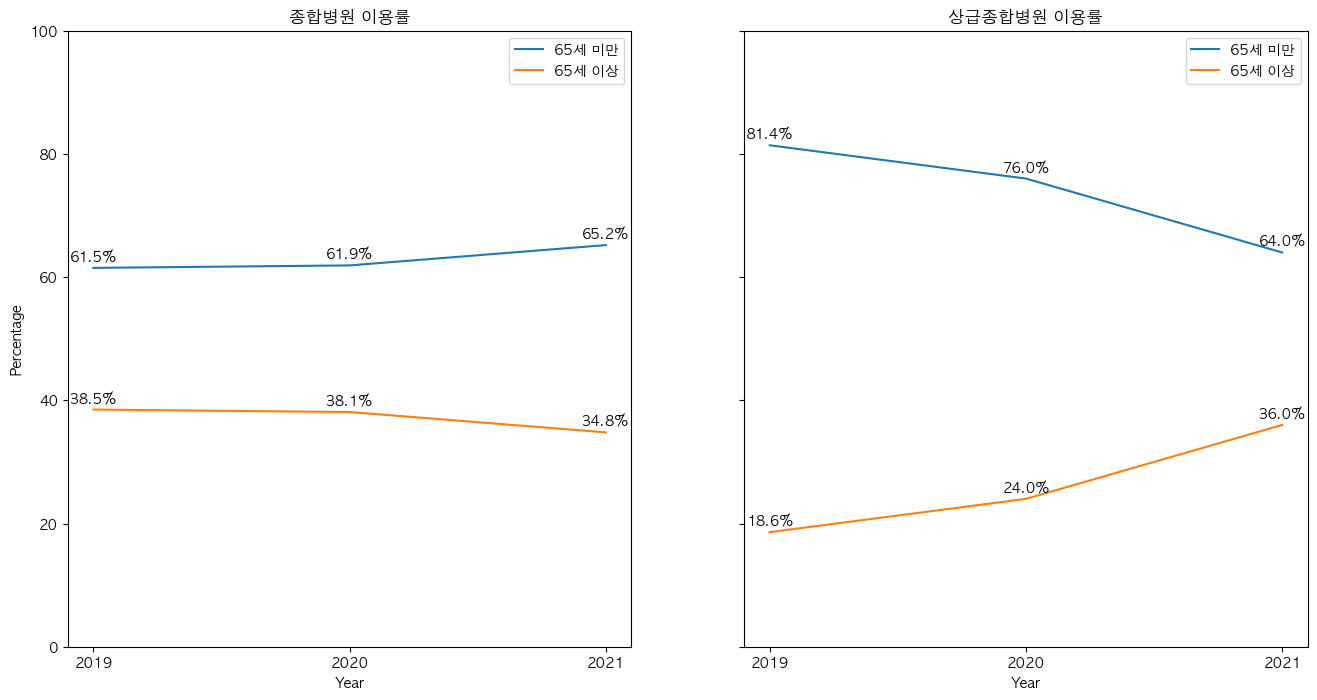

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

sns.lineplot(data=df1, x='Year', y='percentage', hue='Age', ax=axes[0])
axes[0].set_title("종합병원 이용률")
axes[0].set_ylabel("Percentage")
axes[0].set_xlabel("Year")
axes[0].legend(loc='upper right')
axes[0].set_ylim(0, 100)

for i in range(len(df1)):
    axes[0].text(df1['Year'][i], df1['percentage'][i] + 1, f"{df1['percentage'][i]}%", 
                fontsize=10, ha='center')

sns.lineplot(data=df2, x='Year', y='percentage', hue='Age', ax=axes[1])
axes[1].set_title("상급종합병원 이용률")
axes[1].set_ylabel("Percentage")
axes[1].set_xlabel("Year")
axes[1].legend(loc='upper right')

for i in range(len(df2)):
    axes[1].text(df2['Year'][i], df2['percentage'][i] + 1, f"{df2['percentage'][i]}%", 
                fontsize=10, ha='center')
plt.show()

* 65세 이상 병원 이용률이 종합병원인 경우, 소폭 감소하였지만, 상급 종합병원인 경우 대폭 증가하였다.
* 이를 통해 병원의 우선순위가 매우 높은 것을 확인할 수 있다.

In [173]:
station = pd.read_excel('./data/응용 지표(대중교통 이용인원)_20241221.xlsx')
station2 = pd.read_excel('./data/응용 지표(대중교통 이용인원)_20241221 (1).xlsx')
station3 = pd.read_excel('./data/응용 지표(대중교통 이용인원)_20241221 (2).xlsx')

In [180]:
stat = pd.concat([station, station2, station3], ignore_index=True)
stat.drop(index=[0, 2, 4], inplace=True)
stat.reset_index(drop=True, inplace=True)
stat

,시도코드,시도,년,합계,~,경로,국가유공자,어린이,외국인,일반인,장애인,청소년
0,11,서울특별시,2019,1443145759,3,112346401,2519049,16782733,6794548,1212703828,23751586,68247611
1,11,서울특별시,2020,1098488964,13,83342527,1957404,6998296,1051000,947871176,17900392,39368156
2,11,서울특별시,2021,1105857809,10,89546629,1926232,7882250,356934,943934844,17504976,44705934


## 우선순위 2순위 대중교통 접근성

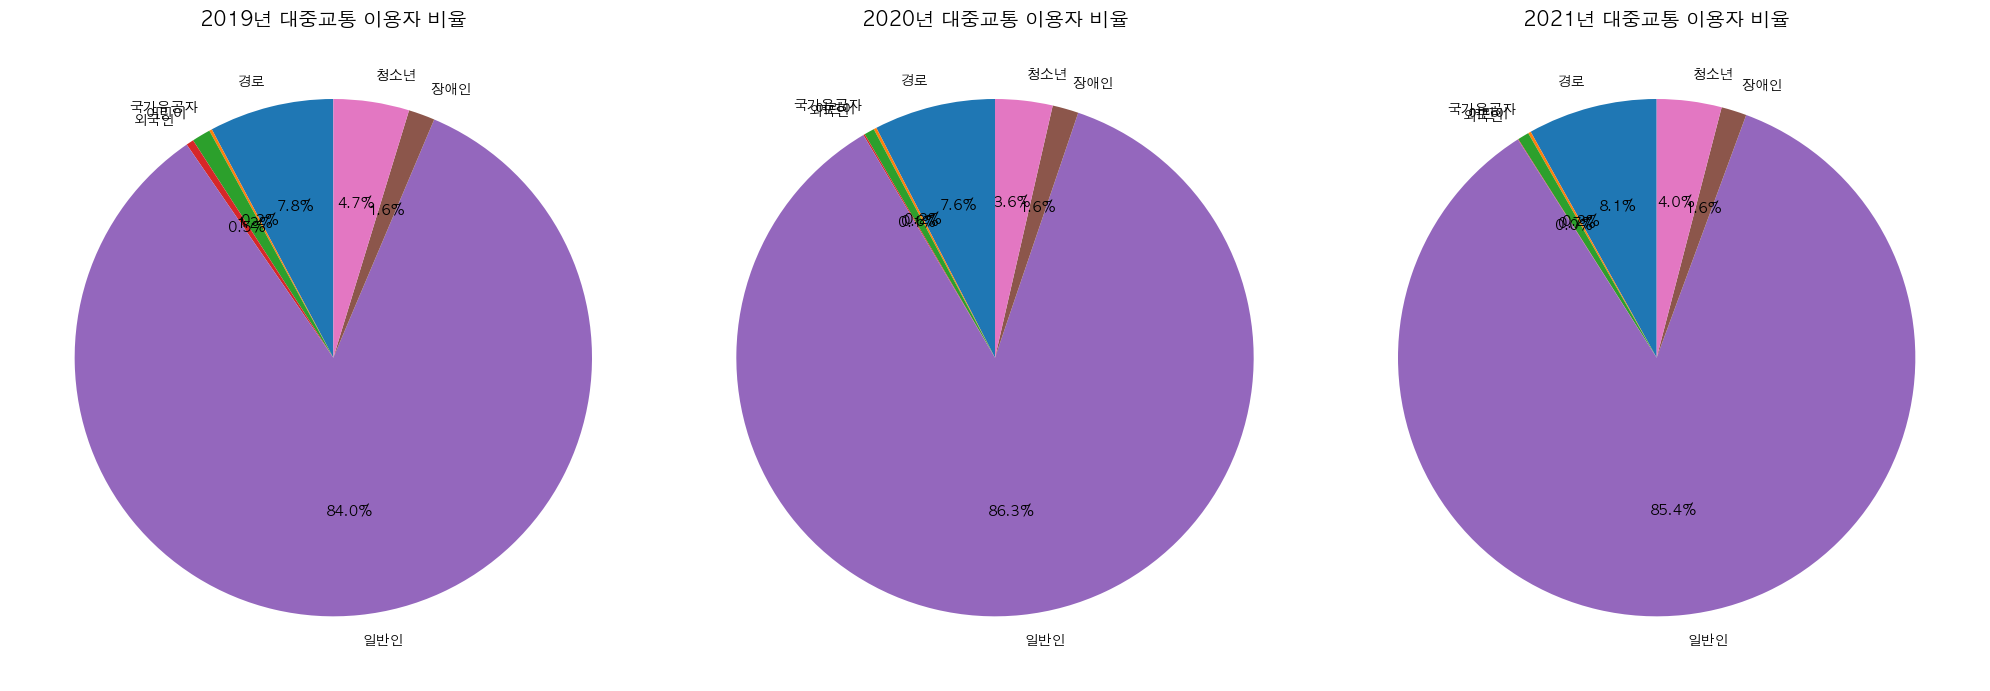

In [185]:
categories = ["경로", "국가유공자", "어린이", "외국인", "일반인", "장애인", "청소년"]

# Subplots 설정
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# 연도별 파이 차트 생성
for idx, year in enumerate([2019, 2020, 2021]):
    year_data = stat[stat["년"] == year]
    values = year_data[categories].iloc[0]
    axes[idx].pie(
        values,
        labels=categories,
        autopct="%.1f%%",
        startangle=90,
        colors=plt.cm.tab10.colors,
    )
    axes[idx].set_title(f"{year}년 대중교통 이용자 비율", fontsize=14)

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

* 65세 이상 고령자 카드 -> 숨기고 ...?
* 생각하지 못한 부분이라 ...?

## 우선순위 3, 4순위 여가생활, 사회활동

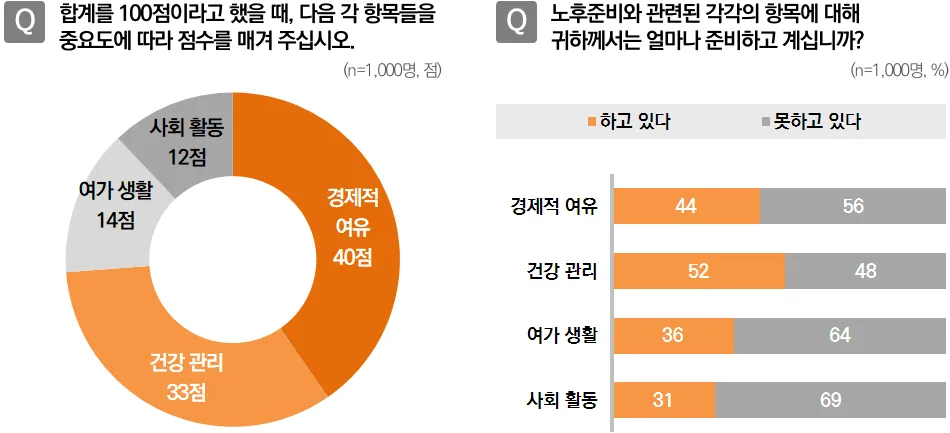

* 3대 요소 -> 의식주
* 의 중에서도 사실 공헌도 또는 참여...?
* 논문 ..? 자료를 찾아보면서..

## 우선순위 5순위 주거비용

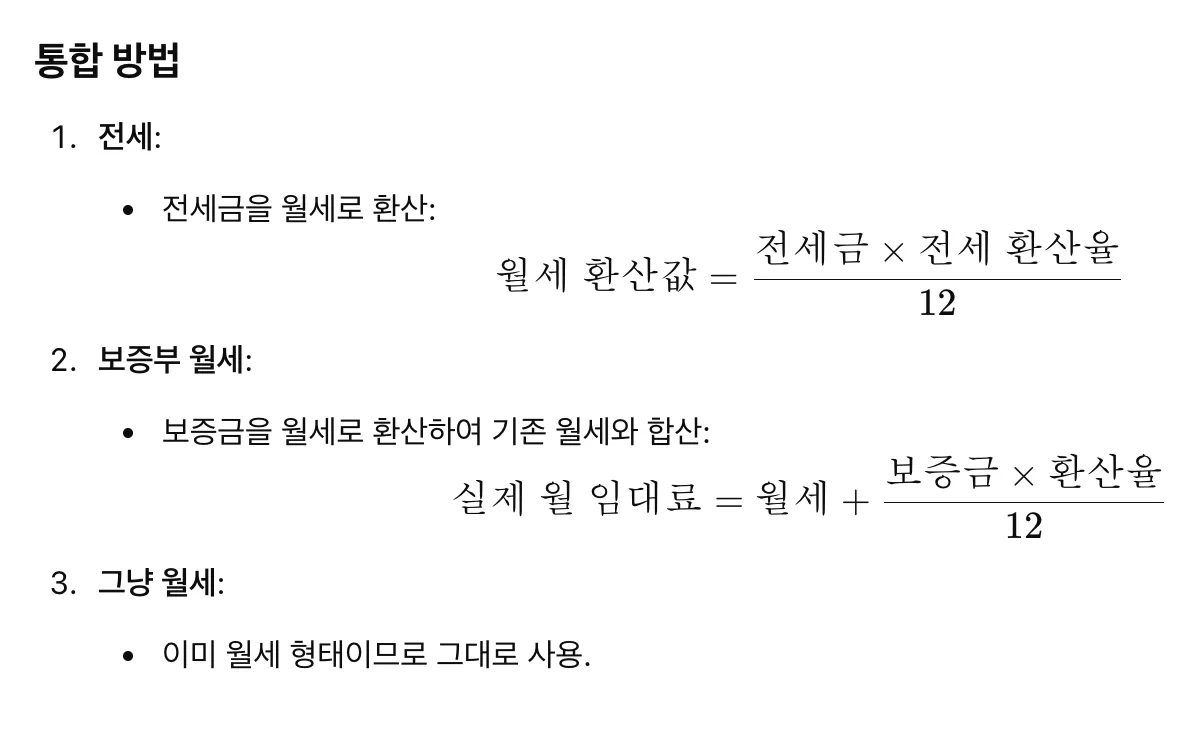

In [14]:
apartments.head()

,구,환산월세금(만원)
0,강남구,98.319739
1,강동구,75.909515
2,강북구,76.267077
3,강서구,75.738096
4,관악구,68.567481
